In [346]:
from tqdm.auto import tqdm
import logging
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from torch.utils.data import random_split
from trl import DPOTrainer
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
import torch.nn.functional as F
import copy
from scipy.stats import entropy
from collections import defaultdict


import torch
torch.cuda.is_available()

True

In [327]:
logging.getLogger("transformers").setLevel(logging.ERROR)

# Level 1

Подгружаем sft модели

In [328]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")
ref_model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")

distilbert-imdb в качестве reward модели

In [329]:
reward_tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
reward_model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

Определяем функции для генерации текста и расчета reward. Параметры генерации особо менять не придется, поэтому я сразу захардкодил более менее оптимальные

In [330]:
def generate_text(text, tokenizer, model, num_seq):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model.generate(
        **encoded_input,
        max_length=100,
        do_sample=True,
        top_k=30,
        top_p=0.9,
        num_return_sequences=num_seq
    )

    return output

In [331]:
def compute_reward(text, tokenizer, model):
    encoded_input = tokenizer.encode(text, return_tensors="pt")
    output = model(encoded_input)
    return output.logits[0][1].item()

Для дальнейшего обучения я решил взять датасет размером 1000. Значит, нужно сгенерировать N=2000 примеров, половина из которых будет winner, а другая - loser. Для того, чтобы примеры были поразнообразнее, я вручную написал 20 промптов, и на каждый промпт будет генериться по 100 примеров. При этом для интереса некоторые промпты сами по себе позитивные, а некоторые - негативные. Мне кажется, это поможет лучше разделять winner и loser, и в целом, любопытно, как обученная модель будет себя вести на негативных промптах.

In [332]:
text_prompts = [
    "The movie is",
    "The plot is",
    "What I liked about the movie is",
    "What I didn't like about the movie is",
    "I watched this movie and",
    "Boring",
    "Hilarious",
    "Predictable",
    "Thrilling",
    "Masterpiece",
    "This film absolutely amazed me with its",
    "I was quite disappointed by the movie because",
    "The most remarkable thing about this film is",
    "Honestly, I expected more from the storyline as",
    "The lead actor's performance was breathtaking due to",
    "Despite its flaws, this movie is worth watching for",
    "The cinematography in this film is outstanding because",
    "I wouldn't recommend this movie since",
    "One thing that sets this film apart is",
    "The soundtrack of the movie added a unique touch by"
    ]

generated_texts = {}
num_seq = 100
for prompt in tqdm(text_prompts, colour="green"):
    outputs = generate_text(prompt, tokenizer, model, num_seq)
    generated_texts[prompt] = []

    for i, output in enumerate(outputs):
        output_text = tokenizer.decode(output, skip_special_tokens=True)
        logit = compute_reward(output_text, reward_tokenizer, reward_model)
        generated_texts[prompt].append((output_text, logit))

    generated_texts[prompt] = sorted(generated_texts[prompt], key=lambda x: -x[1])  # сортируем примеры в каждом промпте
                                                                                    # по убыванию reward

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:39<00:00, 40.98s/it]


## Создание датасета

In [333]:
class DPO_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data["prompt"])

    def __getitem__(self, idx):
        return {
            "prompt": self.data["prompt"][idx],
            "chosen": self.data["chosen"][idx],
            "rejected": self.data["rejected"][idx]
        }


Так как для каждого промпта мы имеем уже отсортированные примеры, то будет брать первую половину из них в качестве winner, а остальную часть как лузеров

In [334]:
half = num_seq // 2
dpo_dataset_dict = {
    "prompt": [],
    "chosen": [],
    "rejected": []
}
for prompt in text_prompts:
    for winner, loser in zip(generated_texts[prompt][:half], generated_texts[prompt][half:]):
        dpo_dataset_dict["prompt"].append(prompt)
        dpo_dataset_dict["chosen"].append(winner[0])
        dpo_dataset_dict["rejected"].append(loser[0])

In [335]:
len(dpo_dataset)

1000

Разбиваем датасет на train и eval 4:1

In [336]:
dpo_dataset = DPO_Dataset(dpo_dataset_dict)
train_size = int(0.8 * len(dpo_dataset))
eval_size = len(dpo_dataset) - train_size
train_dataset, eval_dataset = random_split(dpo_dataset, [train_size, eval_size])

В DPOTrainer многие параметры выставляются по дефолту, но тогда он начинает ругаться со словами "на этот раз прощаю, но в будущем прописывайте все сами", поэтому ниже некоторые параметры дефолтные

In [337]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=5e-5,
    save_strategy="no", 
    evaluation_strategy="epoch",
    remove_unused_columns=False,
)


In [338]:
tokenizer.pad_token_id = tokenizer.eos_token_id   # без этого была ошибка в DPOTrainer с паддингами
                                                  # залез в исходный код DPODataCollatorWithPadding, чтобы найти эту проблему

Копируем модельку, чтобы не затиралась и дальше можно было их сравнивать

In [339]:
model_hinge = copy.deepcopy(model)

## Hinge loss

In [340]:
dpo_trainer = DPOTrainer(
    model=model_hinge,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type='hinge'
)

In [341]:
device = dpo_trainer.model.device
device

device(type='cuda', index=0)

In [342]:
dpo_trainer.train()

{'loss': 0.4201, 'learning_rate': 3.7500000000000003e-05, 'rewards/chosen': -0.8832394480705261, 'rewards/rejected': -2.1156623363494873, 'rewards/accuracies': 0.8125, 'rewards/margins': 1.2324227094650269, 'logps/rejected': -215.47686767578125, 'logps/chosen': -186.98011779785156, 'logits/rejected': -31.96535873413086, 'logits/chosen': -32.67618942260742, 'epoch': 0.5}
{'loss': 0.3014, 'learning_rate': 2.5e-05, 'rewards/chosen': -1.0376734733581543, 'rewards/rejected': -2.688283681869507, 'rewards/accuracies': 0.8999999761581421, 'rewards/margins': 1.6506104469299316, 'logps/rejected': -217.03521728515625, 'logps/chosen': -183.57089233398438, 'logits/rejected': -33.50629806518555, 'logits/chosen': -34.21361541748047, 'epoch': 1.0}
{'eval_loss': 0.29792335629463196, 'eval_runtime': 51.5017, 'eval_samples_per_second': 3.883, 'eval_steps_per_second': 0.485, 'eval_rewards/chosen': -1.351280689239502, 'eval_rewards/rejected': -3.0823774337768555, 'eval_rewards/accuracies': 0.86500000953674

TrainOutput(global_step=200, training_loss=0.196306471824646, metrics={'train_runtime': 1370.2726, 'train_samples_per_second': 1.168, 'train_steps_per_second': 0.146, 'train_loss': 0.196306471824646, 'epoch': 2.0})

У логитов и логирифмических вероятностей какие-то странные значения, которые мне интуитивно не понятны, поэтому я при обучении ориентировался на loss, rewards/accuracies и rewards/margins. Видно, что они к концу обучения приняли достаточно хорошие значения, но, наверное 2 эпохи излишни.

Проверим работоспособность обученной модели, для каждого промпта сгенерим по одному примеру с помощью sft модели и с помощью обученной и посмотрим наглядно

In [343]:
model_hinge.to('cpu')
ref_model.to('cpu')
mean_reward_before = 0
mean_reward_after_hinge = 0
generations_before = []
generations_after_hinge = []
for prompt in text_prompts:
    tmp_out_before = generate_text(prompt, tokenizer, ref_model, 1)
    tmp_text_before = tokenizer.decode(tmp_out_before[0], skip_special_tokens=True)
    tmp_logit_before = compute_reward(tmp_text_before, reward_tokenizer, reward_model)
    
    tmp_out_after = generate_text(prompt, tokenizer, model_hinge, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    print(f"До: {tmp_text_before}\nReward: {tmp_logit_before}")
    print(f"После: {tmp_text_after}\nReward: {tmp_logit_after}\n")
    
    mean_reward_before += tmp_logit_before
    mean_reward_after_hinge += tmp_logit_after
    generations_before.append(tmp_text_before)
    generations_after_hinge.append(tmp_text_after)

mean_reward_before /= len(text_prompts)
mean_reward_after_hinge /= len(text_prompts)

До: The movie is about an army of spies who, under the orders of the President of the United States, are given a secret mission to investigate and destroy a nuclear power plant in order to create a nuclear war. However, after their mission fails, the spy who made the secret mission is killed by the President of the United States in a very unfortunate death.<br /><br />The film contains no plot, nor any of the original material. Instead, it is a very short and non-desc
Reward: -2.331864595413208
После: The movie is a great example of a great story, and it has the same quality that I have always enjoyed.<br /><br />I can't stress this enough; I love the story, the actors, the story and the acting, and I always enjoyed watching it. It's a really great film. I would also like to say, I've heard the story, and I love it. It's great!
Reward: 2.8575401306152344

До: The plot is about a young woman named Lillian who comes to live in the home of a man named James. James decides to get her to st

До: I was quite disappointed by the movie because I felt it had a very strong message. But, it also has a strong message. We all have some kind of dream that will bring us to the future. But, when you see the world that is coming, you wonder what is happening to our lives. We think of things as they are. And, we want to know what the world is like for us, so that our dreams don't go away. What can we ask the world to do
Reward: 1.8242666721343994
После: I was quite disappointed by the movie because I love it as well, but the acting was good and the storyline really had me intrigued. This movie is definitely worth seeing, even if you're a fan of the genre, but if you're not an avid watcher and you've seen it, you'll enjoy it.
Reward: 2.566596031188965

До: The most remarkable thing about this film is its cinematography. It's hard to believe that a movie made in the late 70s could be as beautiful and funny as this. I was amazed at how good it really was.<br /><br />It's hard to say it's 

In [344]:
print(f"Средний reward до обучения: {mean_reward_before}")
print(f"Средний reward после обучения с hinge: {mean_reward_after_hinge}")
print(f"разница между средним значением reward моделей до и после обучения: {mean_reward_after_hinge - mean_reward_before}")

Средний reward до обучения: 0.8084352105855942
Средний reward после обучения с hinge: 2.8297609448432923
разница между средним значением reward моделей до и после обучения: 2.0213257342576982


Хорошо бы конечно отнормировать значения reward, но я слишком поздно об этом подумал. Вообще максимальные reward, которые я наблюдал - около 2.9, поэтому можно сказать, что мы выполнили свою цель и модель хорошо обучилась.

Попробуем подать модели на вход заведомо негативный промпт и посмотрим, как она себя поведет

In [ ]:
tmp_out = generate_text("That was the worst movie I've ever seen", tokenizer, model_hinge, 1)
tmp_text = tokenizer.decode(tmp_out[0], skip_special_tokens=True)
tmp_logit = compute_reward(tmp_text, reward_tokenizer, reward_model)
print(tmp_text, tmp_logit)

Не очень человечно звучит, но главное что позитивно

Теперь рассчитаем diversity

In [347]:
def token_entropy(generations, tokenizer):
    stats = defaultdict(int)
    num_tokens = 0
    for example in generations:
        tokens = tokenizer.encode(example)
        for t in tokens:
            if t == tokenizer.pad_token_id:
                continue
            stats[t] += 1
            num_tokens += 1
    for k in stats.keys():
        stats[k] /= num_tokens
        
    return entropy(list(stats.values()))

In [352]:
print(f"Diversity до: {token_entropy(generations_before, tokenizer)}")
print(f"Diversity после hinge: {token_entropy(generations_after_hinge, tokenizer)}")

Diversity до: 5.272982659374829
Diversity после hinge: 4.6747781311579315


Вполне логично, что разнообразие текстов уменьшится, учитывая, что модель старается больше не генерить отрицательные отзывы. Но при этом уменьшилось оно не так сильно, как я ожидал

## Sigmoid loss

Заменим лосс на сигмоиду и повторим результаты

In [353]:
model_sigmoid = copy.deepcopy(model)

In [354]:
dpo_trainer = DPOTrainer(
    model=model_sigmoid,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="sigmoid"
)

In [355]:
dpo_trainer.train()

{'loss': 0.3869, 'learning_rate': 3.7500000000000003e-05, 'rewards/chosen': -1.5112110376358032, 'rewards/rejected': -3.260859727859497, 'rewards/accuracies': 0.8174999952316284, 'rewards/margins': 1.749648928642273, 'logps/rejected': -226.92886352539062, 'logps/chosen': -193.2598419189453, 'logits/rejected': -30.053285598754883, 'logits/chosen': -30.939889907836914, 'epoch': 0.5}
{'loss': 0.3273, 'learning_rate': 2.5e-05, 'rewards/chosen': -2.094130516052246, 'rewards/rejected': -4.669919490814209, 'rewards/accuracies': 0.8924999833106995, 'rewards/margins': 2.575788974761963, 'logps/rejected': -236.8515625, 'logps/chosen': -194.13548278808594, 'logits/rejected': -30.566577911376953, 'logits/chosen': -31.675498962402344, 'epoch': 1.0}
{'eval_loss': 0.2841319739818573, 'eval_runtime': 45.7534, 'eval_samples_per_second': 4.371, 'eval_steps_per_second': 0.546, 'eval_rewards/chosen': -2.6738762855529785, 'eval_rewards/rejected': -5.442543983459473, 'eval_rewards/accuracies': 0.88999998569

TrainOutput(global_step=200, training_loss=0.20406145989894867, metrics={'train_runtime': 1331.8147, 'train_samples_per_second': 1.201, 'train_steps_per_second': 0.15, 'train_loss': 0.20406145989894867, 'epoch': 2.0})

Тут уже есть намек на переобучение, но да ладно

In [356]:
model_sigmoid.to('cpu')
ref_model.to('cpu')
mean_reward_after_sigmoid = 0
generations_after_sigmoid = []

for prompt in text_prompts:
    tmp_out_before = generate_text(prompt, tokenizer, ref_model, 1)
    tmp_text_before = tokenizer.decode(tmp_out_before[0], skip_special_tokens=True)
    tmp_logit_before = compute_reward(tmp_text_before, reward_tokenizer, reward_model)
    
    tmp_out_after = generate_text(prompt, tokenizer, model_sigmoid, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    print(f"До: {tmp_text_before}\nReward: {tmp_logit_before}")
    print(f"После: {tmp_text_after}\nReward: {tmp_logit_after}\n")
    
    mean_reward_after_sigmoid += tmp_logit_after
    generations_after_sigmoid.append(tmp_text_after)

mean_reward_after_sigmoid /= len(text_prompts)

До: The movie is about an army of spies who, under the orders of the President of the United States, are given a secret mission to investigate and destroy a nuclear power plant in order to create a nuclear war. However, after their mission fails, the spy who made the secret mission is killed by the President of the United States in a very unfortunate death.<br /><br />The film contains no plot, nor any of the original material. Instead, it is a very short and non-desc
Reward: -2.331864595413208
После: The movie is a great example of a great story, and one that I believe is worth seeing again and again.<br /><br />I liked the way this film was told, and I think the actors were great. The cinematography was also very good, and the story was well told. This film is a must-see for anyone interested in the world of film, and I look forward to seeing more of the different ways that films are made and the different ways that films are edited.
Reward: 2.8297038078308105

До: The plot is intere

До: I was quite disappointed by the movie because it seemed to be very long and a little silly. As a matter of fact I was expecting a lot of action and a bit of comedy in the middle. However, it didn't even have the comedy of the movie. What I didn't expect was to have a movie where the hero goes into an underground place and has to find a guy who can talk to him. I guess that is what happened, it just wasn't funny at all.<br /
Reward: -2.7691397666931152
После: I was quite disappointed by the movie because I loved the story and the characters were very interesting, although the story was very different from other romantic comedies of that time, but I liked the main themes, especially the relationship between the two characters, and the way the film shows the relationship between the two families, as well as the friendship between the two children. The film is very interesting to watch again and again, and I think that the film is worth seeing again and again.
Reward: 1.649027585983276

In [357]:
print(f"Средний reward до обучения: {mean_reward_before}")
print(f"Средний reward после обучения с hinge: {mean_reward_after_sigmoid}")
print(f"разница между средним значением reward моделей до и после обучения: {mean_reward_after_sigmoid - mean_reward_before}")

Средний reward до обучения: 0.8084352105855942
Средний reward после обучения с hinge: 2.7732949018478394
разница между средним значением reward моделей до и после обучения: 1.9648596912622454


In [358]:
print(f"Diversity до: {token_entropy(generations_before, tokenizer)}")
print(f"Diversity после hinge: {token_entropy(generations_after_hinge, tokenizer)}")
print(f"Diversity после sigmoid: {token_entropy(generations_after_sigmoid, tokenizer)}")

Diversity до: 5.272982659374829
Diversity после hinge: 4.6747781311579315
Diversity после sigmoid: 4.705272615566063


Видно, что с сигмоидой модель тоже хорошо обучилась, но reward не такой большой, как у hinge лосса (там было 2.829). Ну и логично, что при этом совсем чуть-чуть увеличилось diversity

**Выводы**:

# Level 2

Я изучил код [DPOTrainer](https://github.com/huggingface/trl/blob/7d0a8eea4e01dd4d3247ea3608dec2ec8be10b34/trl/trainer/dpo_trainer.py) и пришел к выводу, что проще всего будет создать от этого класса подкласс и переопределить в нем метод dpo_loss. Надо будет также переопредлить поле loss_type и добавить поле для alpha. dpo_loss я полностью скопирую и просто добавлю туда новые лоссы. В DPO в формуле присутствуют логарифмы внутри сигмоиды, и в целом, там во всем классе все операции с логарифмическими вероятностями и логитами. Так как в задании сказано "проще всего", то просто будет брать экспоненту от этих логарифмов. Тут возникает проблема с тем, что в процессе обучения логарифмы принимают сильно отрицательные значения, из-за которых экспонента уходила в 0 и все значения слетали в nan, поэтому пришлось добавить обрезание их значений. Границы (-10; 10) кажутся нормальным компромиссом

Сперва я определю все f'-дивергенции из таблички в статье, хотя для построения графика использовать будем не все.

In [359]:
def alpha_divergence(u, alpha):
    return (1 - u**(-alpha)) / alpha

In [360]:
def reverse_KL(u):
    return torch.log(u) + 1

In [361]:
def forward_KL(u):
    return -1 / u

In [362]:
def JS_divergence(u):
    return torch.log(2 * u / (1 + u))

In [363]:
def total_variation(u):
    if u > 1:
        return 0.5
    else:
        return -0.5

In [364]:
def chi_squared(u):
    return 2 * (u - 1)

In [365]:
def log_sum_exp(logp):
    b = torch.max(logp)
    return b + torch.log(torch.exp(logp - b).sum())

In [366]:
class MyDPOTrainer(DPOTrainer):
    def __init__(self, **kwargs):
        # переопределяем loss_type и добавлем alpha
        loss_type = kwargs.pop("loss_type", "sigmoid")
        alpha = kwargs.pop("alpha", 0)
        super(MyDPOTrainer, self).__init__(**kwargs)
        self.loss_type = loss_type
        self.alpha = alpha
    
    def dpo_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
        reference_chosen_logps: torch.FloatTensor,
        reference_rejected_logps: torch.FloatTensor,
        reference_free: bool = False,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            policy_chosen_logps: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
            policy_rejected_logps: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
            reference_chosen_logps: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
            reference_rejected_logps: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
            reference_free: If True, we ignore the _provided_ reference model and implicitly use a reference model that assigns equal probability to all responses.

        Returns:
            A tuple of three tensors: (losses, chosen_rewards, rejected_rewards).
            The losses tensor contains the DPO loss for each example in the batch.
            The chosen_rewards and rejected_rewards tensors contain the rewards for the chosen and rejected responses, respectively.
        """
        pi_logratios = policy_chosen_logps - policy_rejected_logps
        if reference_free:
            ref_logratios = 0
        else:
            ref_logratios = reference_chosen_logps - reference_rejected_logps

        logits = pi_logratios - ref_logratios

        # The beta is a temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5.
        # We ignore the reference model as beta -> 0. The label_smoothing parameter encodes our uncertainty about the labels and
        # calculates a conservative DPO loss.
        if self.loss_type == "sigmoid":
            losses = (-F.logsigmoid(self.beta * logits))
        elif self.loss_type == "hinge":
            losses = torch.relu(1 - self.beta * logits)
        elif self.loss_type == "ipo":
            # eqn (17) of the paper where beta is the regularization parameter for the IPO loss, denoted by tau in the paper.
            losses = (logits - 1 / (2 * self.beta)) ** 2
            
        else:
            
            win_logratios = policy_chosen_logps - reference_chosen_logps
            lose_logratios = policy_rejected_logps - reference_rejected_logps
            
            # я поэксперементировал с разными подходами и пришел к выводу, что 
            # у win_logratios и lose_logratios значения по модулю меньше, чем
            # если брать по отдельности логарифмы
            # значит при обрезании мы потеряем меньше информации
            
            win_logratios = torch.clamp(win_logratios, min=-10, max=10)
            lose_logratios = torch.clamp(lose_logratios, min=-10, max=10)
            
            win_ratio = torch.exp(win_logratios)
            lose_ratio = torch.exp(lose_logratios)
            
            # далее вызываем функции по выбранному лоссу
            if self.loss_type == "alpha_divergence":
                if self.alpha > 0 and self.alpha < 1:
                    f_divergence = alpha_divergence(win_ratio, self.alpha) - alpha_divergence(lose_ratio, self.alpha)
                elif self.alpha == 0:
                    print("parameter alpha is 0 or not provided. Reversed KL will be used instead")
                    f_divergence = reverse_KL(win_ratio) - reverse_KL(lose_ratio)
                elif self.alpha == 1:
                    print("parameter alpha is 1. Forward KL will be used instead")
                    f_divergence = forward_KL(win_ratio) - forward_KL(lose_ratio)
                else:
                    raise ValueError("parameter alpha should be 0 < alpha < 1")

            elif self.loss_type == "reverse_KL":
                f_divergence = reverse_KL(win_ratio) - reverse_KL(lose_ratio)
                
            elif self.loss_type == "forward_KL":
                f_divergence = forward_KL(win_ratio) - forward_KL(lose_ratio)
            
            elif self.loss_type == "JS_divergence":
                f_divergence = JS_divergence(win_ratio) - JS_divergence(lose_ratio)
            
            elif self.loss_type == "total_variation":
                f_divergence = total_variation(win_ratio) - total_variation(lose_ratio)
            
            elif self.loss_type == "chi_squared":
                f_divergence = chi_squared(win_ratio) - chi_squared(lose_ratio,)
            
            else:
                raise ValueError(f"Unknown loss type: {self.loss_type}. Should be one of "
                                 f"['sigmoid', 'hinge', 'ipo', 'alpha_divergence', 'reverse_KL', 'forward_KL', "
                                 f"'JS_divergence', 'total_variation', 'chi_squared']")
            losses = (-F.logsigmoid(self.beta * f_divergence))  # здесь и в сигмоиде выше еще был label_smoothing,
            # но видимо, что-то у них поломалось и такого поля больше нет. Есть label_smoother, но он почему-то
            # не инициализировался. По дефолту у них это значения все равно стояло 0, поэтому разницы нет
                

        chosen_rewards = self.beta * (policy_chosen_logps - reference_chosen_logps).detach()
        rejected_rewards = self.beta * (policy_rejected_logps - reference_rejected_logps).detach()

        return losses, chosen_rewards, rejected_rewards

In [367]:
model_fkl = copy.deepcopy(model)
model_alpha_07 = copy.deepcopy(model)
model_alpha_05 = copy.deepcopy(model)
model_alpha_03 = copy.deepcopy(model)
model_jsd = copy.deepcopy(model)
model_rkl = copy.deepcopy(model)

In [408]:
mean_rewards = {}
diversities = {}

Предыдущие две модели обучались 2 эпохи, а лосс на валидации не особо уменьшился, модели даже переобучались. Поэтому следующие модели я буду обучать одну эпоху, для сравнительного анализа этого должно хватить. 

In [369]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=5e-5,
    save_strategy="no", 
    evaluation_strategy="epoch",
    remove_unused_columns=False,
)


## Forward KL

In [370]:
dpo_trainer = MyDPOTrainer(
    model=model_fkl,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="forward_KL", 
)

In [371]:
dpo_trainer.train()

{'loss': 30.661, 'learning_rate': 2.5e-05, 'rewards/chosen': -3.310512065887451, 'rewards/rejected': -4.052464008331299, 'rewards/accuracies': 0.6850000023841858, 'rewards/margins': 0.7419523000717163, 'logps/rejected': -234.8449249267578, 'logps/chosen': -211.25286865234375, 'logits/rejected': -22.7447452545166, 'logits/chosen': -22.985706329345703, 'epoch': 0.5}
{'loss': 0.6914, 'learning_rate': 0.0, 'rewards/chosen': -6.918935775756836, 'rewards/rejected': -8.019194602966309, 'rewards/accuracies': 0.6549999713897705, 'rewards/margins': 1.1002581119537354, 'logps/rejected': -270.34429931640625, 'logps/chosen': -242.38351440429688, 'logits/rejected': -11.553863525390625, 'logits/chosen': -12.064510345458984, 'epoch': 1.0}
{'eval_loss': 8.402140617370605, 'eval_runtime': 81.1269, 'eval_samples_per_second': 2.465, 'eval_steps_per_second': 0.308, 'eval_rewards/chosen': -7.627157211303711, 'eval_rewards/rejected': -8.351749420166016, 'eval_rewards/accuracies': 0.6299999952316284, 'eval_re

TrainOutput(global_step=100, training_loss=15.67621021270752, metrics={'train_runtime': 617.0107, 'train_samples_per_second': 1.297, 'train_steps_per_second': 0.162, 'train_loss': 15.67621021270752, 'epoch': 1.0})

Нет слов, чтобы прокомментировать данные метрики, поэтому просто посмотрим, как модель отработает на инференсе

In [409]:
model_fkl.to('cpu')
mean_reward_after_fkl = 0
generations_after_fkl = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_fkl, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_fkl += tmp_logit_after
    generations_after_fkl.append(tmp_text_after)

mean_reward_after_fkl /= len(text_prompts)

In [410]:
print(f"Средний reward после forward KL: {mean_reward_after_fkl}")
tmp_entropy = token_entropy(generations_after_fkl, tokenizer)
print(f"Diversity после forward KL: {tmp_entropy}")
mean_rewards["FKL"] = mean_reward_after_fkl
diversities["FKL"] = tmp_entropy

Средний reward после forward KL: 2.5436355769634247
Diversity после forward KL: 4.6450253639911825


Получилось вполне нормально, и вообще я очень рад, что в целом это работает. Сравнивать с предыдущими моделями нет смысла, тут только 1 эпоха, поэтому посмотрим на следующие

## Alpha divergence

### alpha = 0.7

In [323]:
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=5e-5,
    save_strategy="no", 
    evaluation_strategy="epoch",
    remove_unused_columns=False,
)


In [374]:
dpo_trainer = MyDPOTrainer(
    model=model_alpha_07,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="alpha_divergence",
    alpha=0.7
)

In [375]:
dpo_trainer.train()

{'loss': 2.8895, 'learning_rate': 2.5e-05, 'rewards/chosen': -3.6690337657928467, 'rewards/rejected': -4.577442169189453, 'rewards/accuracies': 0.6700000166893005, 'rewards/margins': 0.9084087610244751, 'logps/rejected': -240.09471130371094, 'logps/chosen': -214.8380889892578, 'logits/rejected': -29.005937576293945, 'logits/chosen': -29.232526779174805, 'epoch': 0.5}
{'loss': 1.7478, 'learning_rate': 0.0, 'rewards/chosen': -5.939403533935547, 'rewards/rejected': -7.223630428314209, 'rewards/accuracies': 0.6725000143051147, 'rewards/margins': 1.284226894378662, 'logps/rejected': -262.388671875, 'logps/chosen': -232.58819580078125, 'logits/rejected': -25.112998962402344, 'logits/chosen': -25.328969955444336, 'epoch': 1.0}
{'eval_loss': 0.6931471824645996, 'eval_runtime': 83.4509, 'eval_samples_per_second': 2.397, 'eval_steps_per_second': 0.3, 'eval_rewards/chosen': -6.616110801696777, 'eval_rewards/rejected': -7.798962593078613, 'eval_rewards/accuracies': 0.6850000023841858, 'eval_reward

TrainOutput(global_step=100, training_loss=2.3186421966552735, metrics={'train_runtime': 688.4515, 'train_samples_per_second': 1.162, 'train_steps_per_second': 0.145, 'train_loss': 2.3186421966552735, 'epoch': 1.0})

In [411]:
model_alpha_07.to('cpu')
mean_reward_after_alpha_07 = 0
generations_after_alpha_07 = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_alpha_07, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_alpha_07 += tmp_logit_after
    generations_after_alpha_07.append(tmp_text_after)

mean_reward_after_alpha_07 /= len(text_prompts)

In [412]:
print(f"Средний reward после alpha divergency (alpha=0.7): {mean_reward_after_alpha_07}")
tmp_entropy = token_entropy(generations_after_alpha_07, tokenizer)
print(f"Diversity после alpha divergency (alpha=0.7): {tmp_entropy}")
mean_rewards["alpha=0.7"] = mean_reward_after_alpha_07
diversities["alpha=0.7"] = tmp_entropy

Средний reward после alpha divergency (alpha=0.7): 2.754124414920807
Diversity после alpha divergency (alpha=0.7): 4.6614452641024275


Получилось еще лучше, чем у forward KL, идем дальше

### alpha = 0.5

In [378]:
dpo_trainer = MyDPOTrainer(
    model=model_alpha_05,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="alpha_divergence",
    alpha=0.5
)

In [379]:
dpo_trainer.train()

{'loss': 0.9295, 'learning_rate': 2.5e-05, 'rewards/chosen': -1.059504508972168, 'rewards/rejected': -1.9710023403167725, 'rewards/accuracies': 0.8050000071525574, 'rewards/margins': 0.9114977121353149, 'logps/rejected': -214.0302734375, 'logps/chosen': -188.7427978515625, 'logits/rejected': -29.907426834106445, 'logits/chosen': -30.22368621826172, 'epoch': 0.5}
{'loss': 1.1065, 'learning_rate': 0.0, 'rewards/chosen': -3.533815860748291, 'rewards/rejected': -5.094961643218994, 'rewards/accuracies': 0.7749999761581421, 'rewards/margins': 1.5611456632614136, 'logps/rejected': -241.10198974609375, 'logps/chosen': -208.5323028564453, 'logits/rejected': -24.706188201904297, 'logits/chosen': -25.035011291503906, 'epoch': 1.0}
{'eval_loss': 0.7722246050834656, 'eval_runtime': 54.9687, 'eval_samples_per_second': 3.638, 'eval_steps_per_second': 0.455, 'eval_rewards/chosen': -3.979597806930542, 'eval_rewards/rejected': -5.623938083648682, 'eval_rewards/accuracies': 0.7699999809265137, 'eval_rewa

TrainOutput(global_step=100, training_loss=1.0180060958862305, metrics={'train_runtime': 619.7142, 'train_samples_per_second': 1.291, 'train_steps_per_second': 0.161, 'train_loss': 1.0180060958862305, 'epoch': 1.0})

In [413]:
model_alpha_05.to('cpu')
mean_reward_after_alpha_05 = 0
generations_after_alpha_05 = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_alpha_05, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_alpha_05 += tmp_logit_after
    generations_after_alpha_05.append(tmp_text_after)

mean_reward_after_alpha_05 /= len(text_prompts)

In [414]:
print(f"Средний reward после alpha divergency (alpha=0.5): {mean_reward_after_alpha_05}")
tmp_entropy = token_entropy(generations_after_alpha_05, tokenizer)
print(f"Diversity после alpha divergency (alpha=0.5): {tmp_entropy}")
mean_rewards["alpha=0.5"] = mean_reward_after_alpha_05
diversities["alpha=0.5"] = tmp_entropy

Средний reward после alpha divergency (alpha=0.5): 2.8503224730491636
Diversity после alpha divergency (alpha=0.5): 4.773094676758365


Пока что тенденция, описанная в статье сохраняется, с уменьшением alpha увеличивается reward

### alpha = 0.3

In [382]:
dpo_trainer = MyDPOTrainer(
    model=model_alpha_03,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="alpha_divergence",
    alpha=0.3
)

In [383]:
dpo_trainer.train()

{'loss': 0.7259, 'learning_rate': 2.5e-05, 'rewards/chosen': -2.2433178424835205, 'rewards/rejected': -3.2306206226348877, 'rewards/accuracies': 0.762499988079071, 'rewards/margins': 0.9873025417327881, 'logps/rejected': -226.62648010253906, 'logps/chosen': -200.5809326171875, 'logits/rejected': -29.323835372924805, 'logits/chosen': -29.710617065429688, 'epoch': 0.5}
{'loss': 0.6825, 'learning_rate': 0.0, 'rewards/chosen': -3.5586743354797363, 'rewards/rejected': -4.76800537109375, 'rewards/accuracies': 0.7674999833106995, 'rewards/margins': 1.2093312740325928, 'logps/rejected': -237.83242797851562, 'logps/chosen': -208.78089904785156, 'logits/rejected': -28.124494552612305, 'logits/chosen': -28.29892349243164, 'epoch': 1.0}
{'eval_loss': 0.6800270676612854, 'eval_runtime': 48.8535, 'eval_samples_per_second': 4.094, 'eval_steps_per_second': 0.512, 'eval_rewards/chosen': -3.522468328475952, 'eval_rewards/rejected': -4.708394527435303, 'eval_rewards/accuracies': 0.7749999761581421, 'eval

TrainOutput(global_step=100, training_loss=0.704199447631836, metrics={'train_runtime': 613.6581, 'train_samples_per_second': 1.304, 'train_steps_per_second': 0.163, 'train_loss': 0.704199447631836, 'epoch': 1.0})

In [435]:
model_alpha_03.to('cpu')
mean_reward_after_alpha_03 = 0
generations_after_alpha_03 = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_alpha_03, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_alpha_03 += tmp_logit_after
    generations_after_alpha_03.append(tmp_text_after)

mean_reward_after_alpha_03 /= len(text_prompts)

In [436]:
print(f"Средний reward после alpha divergency (alpha=0.3): {mean_reward_after_alpha_03}")
tmp_entropy = token_entropy(generations_after_alpha_03, tokenizer)
print(f"Diversity после alpha divergency (alpha=0.3): {tmp_entropy}")
mean_rewards["alpha=0.3"] = mean_reward_after_alpha_03
diversities["alpha=0.3"] = tmp_entropy

Средний reward после alpha divergency (alpha=0.3): 2.733752828836441
Diversity после alpha divergency (alpha=0.3): 4.436646612171559


Тенденция нарушилась, но было близко..

## JS divergence

In [388]:
dpo_trainer = MyDPOTrainer(
    model=model_jsd,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="JS_divergence",
)

In [389]:
dpo_trainer.train()

{'loss': 0.5564, 'learning_rate': 2.5e-05, 'rewards/chosen': -0.1611463576555252, 'rewards/rejected': -1.0767046213150024, 'rewards/accuracies': 0.8025000095367432, 'rewards/margins': 0.9155583381652832, 'logps/rejected': -205.08731079101562, 'logps/chosen': -179.7592010498047, 'logits/rejected': -32.834495544433594, 'logits/chosen': -33.16696548461914, 'epoch': 0.5}
{'loss': 0.5189, 'learning_rate': 0.0, 'rewards/chosen': -0.287691205739975, 'rewards/rejected': -1.7151776552200317, 'rewards/accuracies': 0.8849999904632568, 'rewards/margins': 1.427486538887024, 'logps/rejected': -207.30413818359375, 'logps/chosen': -176.07107543945312, 'logits/rejected': -34.35993576049805, 'logits/chosen': -34.4959716796875, 'epoch': 1.0}
{'eval_loss': 0.5437495708465576, 'eval_runtime': 89.6157, 'eval_samples_per_second': 2.232, 'eval_steps_per_second': 0.279, 'eval_rewards/chosen': -0.32544177770614624, 'eval_rewards/rejected': -1.636510968208313, 'eval_rewards/accuracies': 0.8650000095367432, 'eval

TrainOutput(global_step=100, training_loss=0.5376432609558105, metrics={'train_runtime': 695.0834, 'train_samples_per_second': 1.151, 'train_steps_per_second': 0.144, 'train_loss': 0.5376432609558105, 'epoch': 1.0})

In [417]:
model_jsd.to('cpu')
mean_reward_after_jsd = 0
generations_after_jsd = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_jsd, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_jsd += tmp_logit_after
    generations_after_jsd.append(tmp_text_after)

mean_reward_after_jsd /= len(text_prompts)

In [418]:
print(f"Средний reward после JS divergency: {mean_reward_after_jsd}")
tmp_entropy = token_entropy(generations_after_jsd, tokenizer)
print(f"Diversity после JS divergency: {tmp_entropy}")
mean_rewards["JSD"] = mean_reward_after_jsd
diversities["JSD"] = tmp_entropy

Средний reward после JS divergency: 2.7998172283172607
Diversity после JS divergency: 4.688542552984192


Снова хорошие результаты, но почему-то уклон в сторону diversity, а не reward, по сравнению с alpha=0.3

## Reverse KL

In [392]:
dpo_trainer = MyDPOTrainer(
    model=model_rkl,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="reverse_KL", 
)

In [393]:
dpo_trainer.train()

{'loss': 0.4871, 'learning_rate': 2.5e-05, 'rewards/chosen': 0.30893683433532715, 'rewards/rejected': -0.6189883947372437, 'rewards/accuracies': 0.8149999976158142, 'rewards/margins': 0.927925169467926, 'logps/rejected': -200.51016235351562, 'logps/chosen': -175.05838012695312, 'logits/rejected': -34.460350036621094, 'logits/chosen': -34.970088958740234, 'epoch': 0.5}
{'loss': 0.4243, 'learning_rate': 0.0, 'rewards/chosen': 0.43083685636520386, 'rewards/rejected': -0.9004485607147217, 'rewards/accuracies': 0.8974999785423279, 'rewards/margins': 1.3312853574752808, 'logps/rejected': -199.1568603515625, 'logps/chosen': -168.88580322265625, 'logits/rejected': -35.492427825927734, 'logits/chosen': -35.52595520019531, 'epoch': 1.0}
{'eval_loss': 0.43527752161026, 'eval_runtime': 82.8619, 'eval_samples_per_second': 2.414, 'eval_steps_per_second': 0.302, 'eval_rewards/chosen': 0.43341121077537537, 'eval_rewards/rejected': -0.8253872394561768, 'eval_rewards/accuracies': 0.8899999856948853, 'ev

TrainOutput(global_step=100, training_loss=0.45567386627197265, metrics={'train_runtime': 684.9127, 'train_samples_per_second': 1.168, 'train_steps_per_second': 0.146, 'train_loss': 0.45567386627197265, 'epoch': 1.0})

In [419]:
model_rkl.to('cpu')
mean_reward_after_rkl = 0
generations_after_rkl = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_rkl, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_rkl += tmp_logit_after
    generations_after_rkl.append(tmp_text_after)

mean_reward_after_rkl /= len(text_prompts)

In [420]:
print(f"Средний reward после reverse KL: {mean_reward_after_rkl}")
tmp_entropy = token_entropy(generations_after_rkl, tokenizer)
print(f"Diversity после reverse KL: {tmp_entropy}")
mean_rewards["RKL"] = mean_reward_after_rkl
diversities["RKL"] = tmp_entropy

Средний reward после reverse KL: 2.788661015033722
Diversity после reverse KL: 4.7279234993143024


Представим полученные результаты на графике

### График

In [402]:
import matplotlib.pyplot as plt
import seaborn as sns

In [423]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 14
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

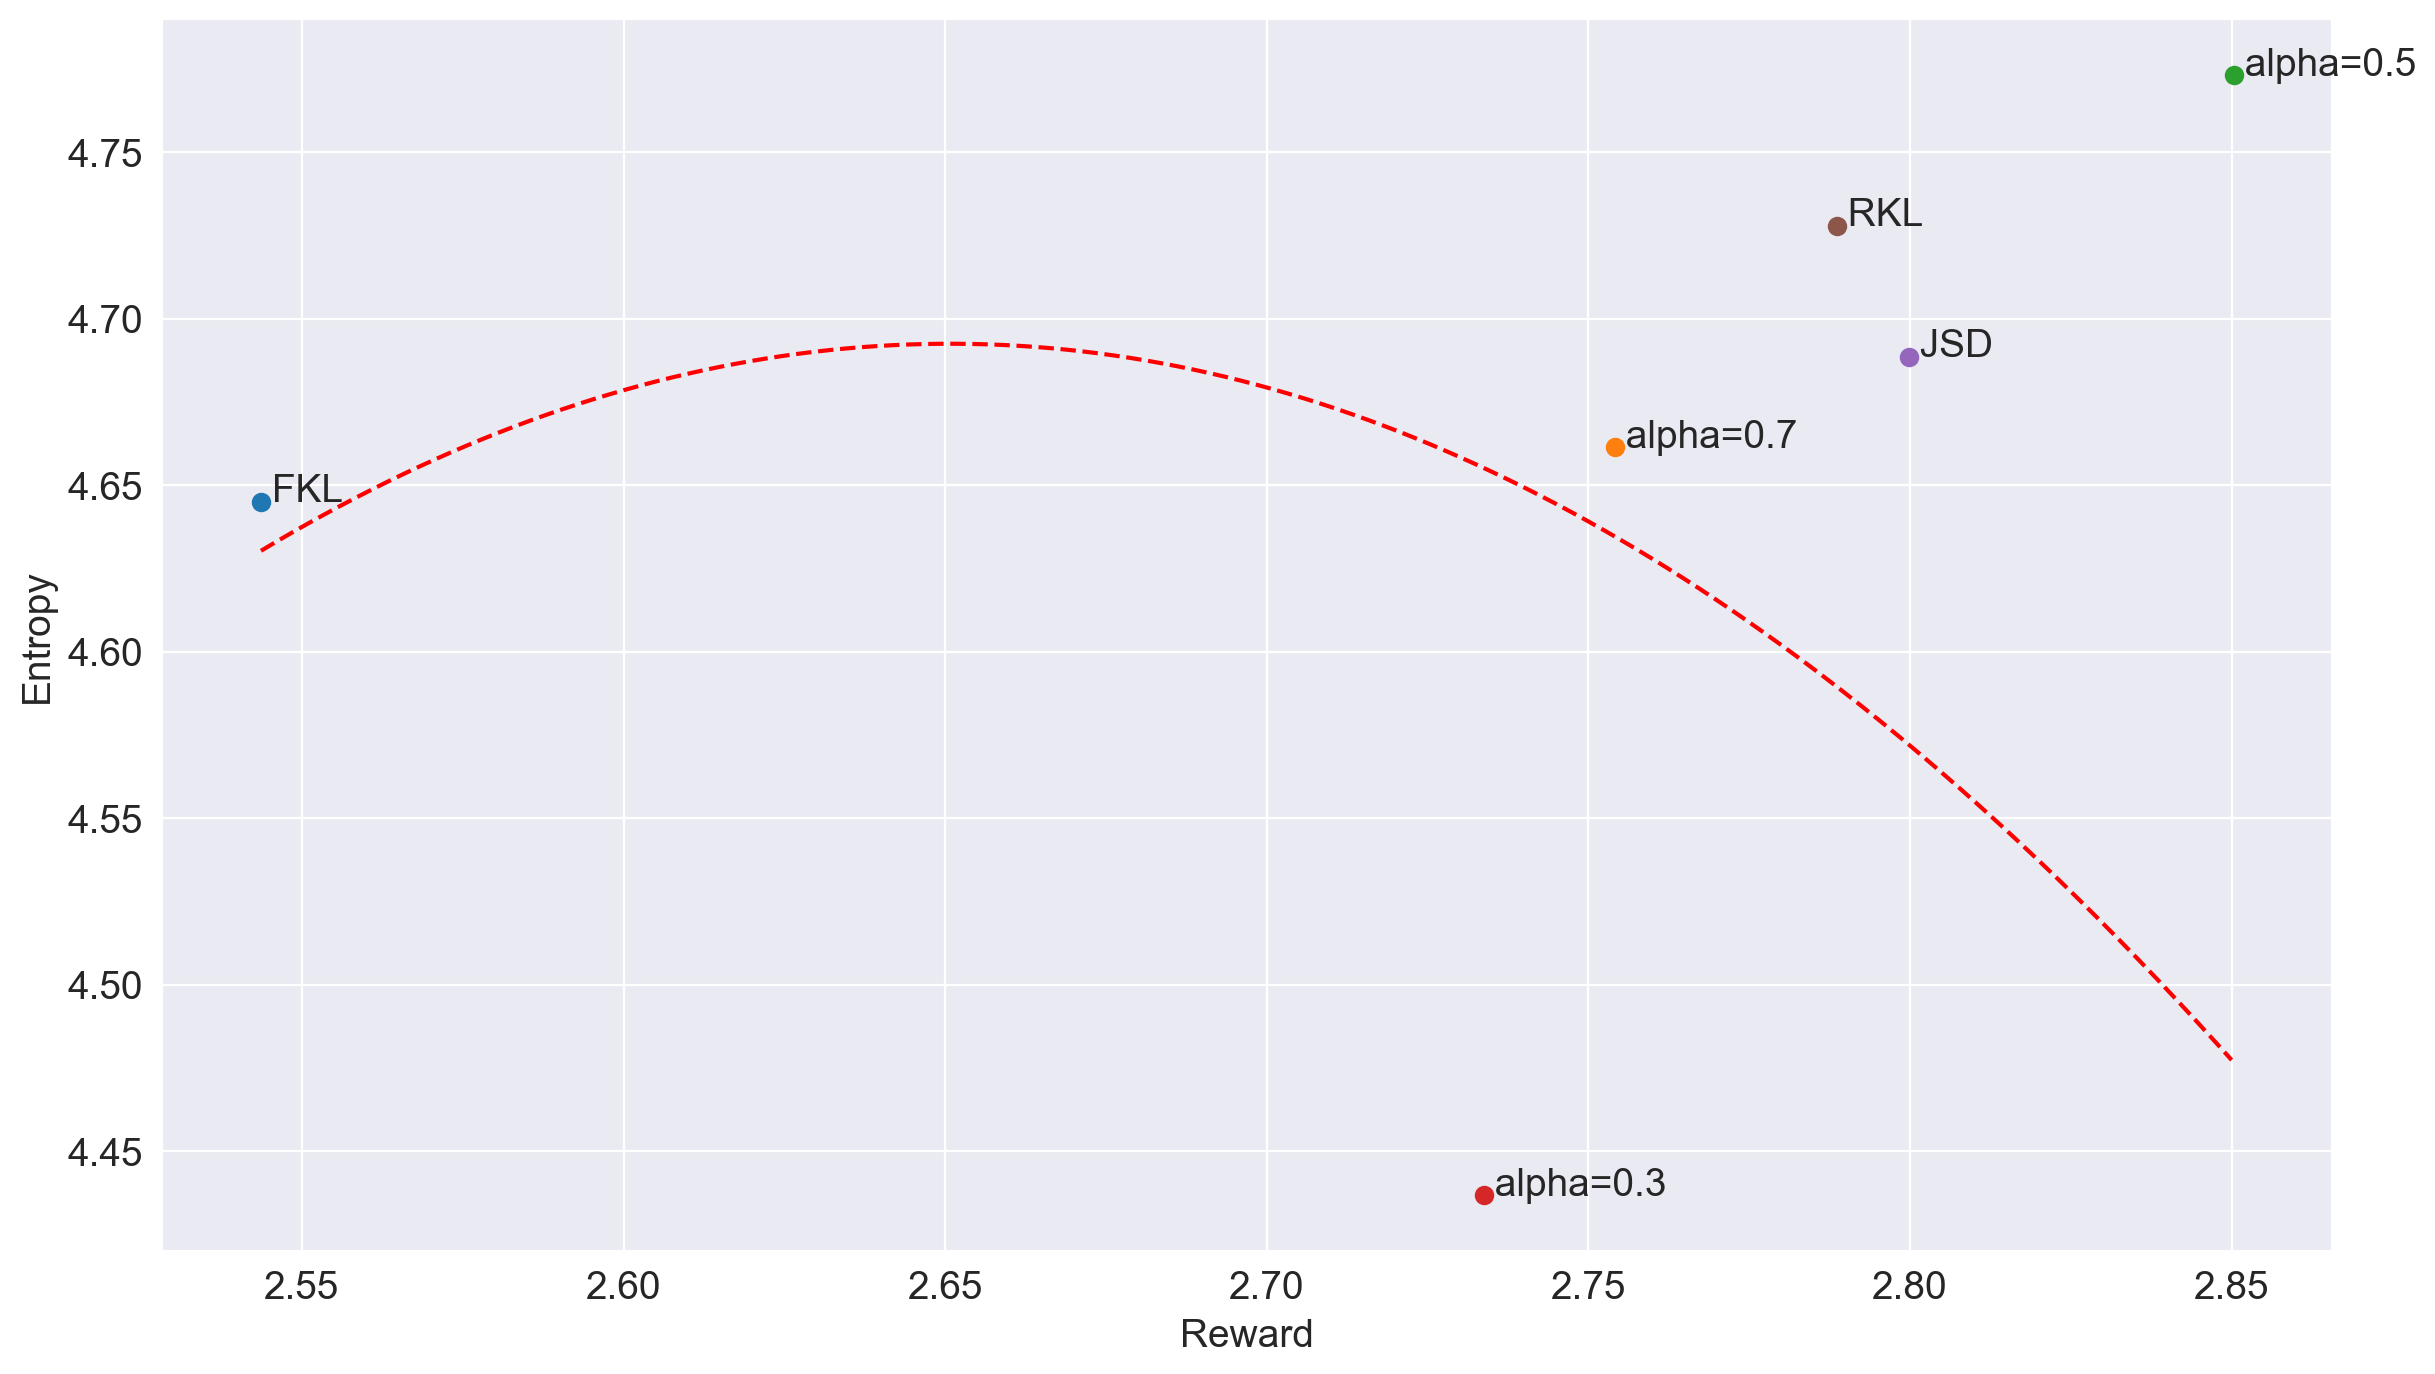

In [440]:
rewards = [mean_rewards["FKL"], 2.65, mean_rewards["alpha=0.7"], 2.8, 2.85]
entropies = [diversities["FKL"], 4.65, diversities["alpha=0.7"], 4.6, 4.45]

coefficients = np.polyfit(rewards, entropies, 2)
polynomial = np.poly1d(coefficients)

x_smooth = np.linspace(min(rewards), max(rewards), 500)
y_smooth = polynomial(x_smooth)

for k in diversities.keys():
    plt.scatter(mean_rewards[k], diversities[k], label=k)
    plt.text(mean_rewards[k], diversities[k], f' {k}')

plt.plot(x_smooth, y_smooth, 'r--')

plt.xlabel('Reward')
plt.ylabel('Entropy')

plt.show()

Получившийся график, конечно, совсем не похож на то, что было в статье. Красной линией я нарисовал то, на что это могло бы быть похоже при большей удаче. Можно оправдаться тем, что бой был в неравных условиях, и у меня не было ресурсов, чтобы сгенерить побольше выборки и делать инференс на большем количестве примеров. С графиком из статьи здесь совпадает только FKL, но в целом можно отметить, что хоть значения reward не отнормированы, модели достаточно хорошо обучились, и как мне кажется, тут просто нужно использовать больше данных для более точных результатов

# Level 3

Какой-то новый лосс с математическим обоснованием его превосходства я не вывел, а перебирать какие-то гиперпараметры - это не то, что требуется. Поэтому я подумал так: на Level 1 hinge дал нам reward немного больше, чем сигмоида. Почему бы не попробовать объединить его с, например, alpha divergence при alpha=0.3 и посмотреть, как изменятся результаты. Все-таки hinge хорошо работает в задачах классификации и, возможно, тут он покажет себя лучше сигмоиды.

In [426]:
class MyDPOTrainer(DPOTrainer):
    def __init__(self, **kwargs):
        # переопределяем loss_type и добавлем alpha
        loss_type = kwargs.pop("loss_type", "sigmoid")
        alpha = kwargs.pop("alpha", 0)
        super(MyDPOTrainer, self).__init__(**kwargs)
        self.loss_type = loss_type
        self.alpha = alpha
    
    def dpo_loss(
        self,
        policy_chosen_logps: torch.FloatTensor,
        policy_rejected_logps: torch.FloatTensor,
        reference_chosen_logps: torch.FloatTensor,
        reference_rejected_logps: torch.FloatTensor,
        reference_free: bool = False,
    ) -> Tuple[torch.FloatTensor, torch.FloatTensor, torch.FloatTensor]:
        """Compute the DPO loss for a batch of policy and reference model log probabilities.

        Args:
            policy_chosen_logps: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
            policy_rejected_logps: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
            reference_chosen_logps: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
            reference_rejected_logps: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
            reference_free: If True, we ignore the _provided_ reference model and implicitly use a reference model that assigns equal probability to all responses.

        Returns:
            A tuple of three tensors: (losses, chosen_rewards, rejected_rewards).
            The losses tensor contains the DPO loss for each example in the batch.
            The chosen_rewards and rejected_rewards tensors contain the rewards for the chosen and rejected responses, respectively.
        """
        pi_logratios = policy_chosen_logps - policy_rejected_logps
        if reference_free:
            ref_logratios = 0
        else:
            ref_logratios = reference_chosen_logps - reference_rejected_logps

        logits = pi_logratios - ref_logratios

        # The beta is a temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5.
        # We ignore the reference model as beta -> 0. The label_smoothing parameter encodes our uncertainty about the labels and
        # calculates a conservative DPO loss.
        if self.loss_type == "sigmoid":
            losses = (-F.logsigmoid(self.beta * logits))
        elif self.loss_type == "hinge":
            losses = torch.relu(1 - self.beta * logits)
        elif self.loss_type == "ipo":
            # eqn (17) of the paper where beta is the regularization parameter for the IPO loss, denoted by tau in the paper.
            losses = (logits - 1 / (2 * self.beta)) ** 2
            
        else:
            
            win_logratios = policy_chosen_logps - reference_chosen_logps
            lose_logratios = policy_rejected_logps - reference_rejected_logps
            
            # я поэксперементировал с разными подходами и пришел к выводу, что 
            # у win_logratios и lose_logratios значения по модулю меньше, чем
            # если брать по отдельности логарифмы
            # значит при обрезании мы потеряем меньше информации
            
            win_logratios = torch.clamp(win_logratios, min=-10, max=10)
            lose_logratios = torch.clamp(lose_logratios, min=-10, max=10)
            
            win_ratio = torch.exp(win_logratios)
            lose_ratio = torch.exp(lose_logratios)
            
            # далее вызываем функции по выбранному лоссу
            if self.loss_type == "alpha_divergence":
                if self.alpha > 0 and self.alpha < 1:
                    f_divergence = alpha_divergence(win_ratio, self.alpha) - alpha_divergence(lose_ratio, self.alpha)
                elif self.alpha == 0:
                    print("parameter alpha is 0 or not provided. Reversed KL will be used instead")
                    f_divergence = reverse_KL(win_ratio) - reverse_KL(lose_ratio)
                elif self.alpha == 1:
                    print("parameter alpha is 1. Forward KL will be used instead")
                    f_divergence = forward_KL(win_ratio) - forward_KL(lose_ratio)
                else:
                    raise ValueError("parameter alpha should be 0 < alpha < 1")

            elif self.loss_type == "reverse_KL":
                f_divergence = reverse_KL(win_ratio) - reverse_KL(lose_ratio)
                
            elif self.loss_type == "forward_KL":
                f_divergence = forward_KL(win_ratio) - forward_KL(lose_ratio)
            
            elif self.loss_type == "JS_divergence":
                f_divergence = JS_divergence(win_ratio) - JS_divergence(lose_ratio)
            
            elif self.loss_type == "total_variation":
                f_divergence = total_variation(win_ratio) - total_variation(lose_ratio)
            
            elif self.loss_type == "chi_squared":
                f_divergence = chi_squared(win_ratio) - chi_squared(lose_ratio,)
            
            else:
                raise ValueError(f"Unknown loss type: {self.loss_type}. Should be one of "
                                 f"['sigmoid', 'hinge', 'ipo', 'alpha_divergence', 'reverse_KL', 'forward_KL', "
                                 f"'JS_divergence', 'total_variation', 'chi_squared']")
            
            losses = torch.relu(1 - self.beta * f_divergence)  # меняем сигмоиду на что-то похожее на hinge
                

        chosen_rewards = self.beta * (policy_chosen_logps - reference_chosen_logps).detach()
        rejected_rewards = self.beta * (policy_rejected_logps - reference_rejected_logps).detach()

        return losses, chosen_rewards, rejected_rewards

In [427]:
dpo_trainer = MyDPOTrainer(
    model=model_alpha_03,
    ref_model=ref_model,
    args=training_args,
    beta=0.1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    padding_value=0,
    max_length=512,
    max_prompt_length=128,
    loss_type="alpha_divergence",
    alpha=0.3
)

In [428]:
dpo_trainer.train()

{'loss': 0.9371, 'learning_rate': 2.5e-05, 'rewards/chosen': -3.773660898208618, 'rewards/rejected': -6.024072170257568, 'rewards/accuracies': 0.8125, 'rewards/margins': 2.250410795211792, 'logps/rejected': -254.56097412109375, 'logps/chosen': -215.88433837890625, 'logits/rejected': -30.369829177856445, 'logits/chosen': -31.015256881713867, 'epoch': 0.5}
{'loss': 0.9721, 'learning_rate': 0.0, 'rewards/chosen': -6.047310829162598, 'rewards/rejected': -7.696506977081299, 'rewards/accuracies': 0.6875, 'rewards/margins': 1.6491965055465698, 'logps/rejected': -267.117431640625, 'logps/chosen': -233.66725158691406, 'logits/rejected': -34.267723083496094, 'logits/chosen': -34.32316589355469, 'epoch': 1.0}
{'eval_loss': 1.025890827178955, 'eval_runtime': 50.6686, 'eval_samples_per_second': 3.947, 'eval_steps_per_second': 0.493, 'eval_rewards/chosen': -6.476222991943359, 'eval_rewards/rejected': -7.955394268035889, 'eval_rewards/accuracies': 0.6800000071525574, 'eval_rewards/margins': 1.4791716

TrainOutput(global_step=100, training_loss=0.9545833969116211, metrics={'train_runtime': 600.9969, 'train_samples_per_second': 1.331, 'train_steps_per_second': 0.166, 'train_loss': 0.9545833969116211, 'epoch': 1.0})

In [429]:
model_alpha_03.to('cpu')
mean_reward_after_alpha_03 = 0
generations_after_alpha_03 = []

for prompt in text_prompts:
    tmp_out_after = generate_text(prompt, tokenizer, model_alpha_03, 1)
    tmp_text_after = tokenizer.decode(tmp_out_after[0], skip_special_tokens=True)
    tmp_logit_after = compute_reward(tmp_text_after, reward_tokenizer, reward_model)
    
    mean_reward_after_alpha_03 += tmp_logit_after
    generations_after_alpha_03.append(tmp_text_after)

mean_reward_after_alpha_03 /= len(text_prompts)

In [430]:
print(f"Средний reward после alpha divergency (alpha=0.3): {mean_reward_after_alpha_03}")
tmp_entropy = token_entropy(generations_after_alpha_03, tokenizer)
print(f"Diversity после alpha divergency (alpha=0.3): {tmp_entropy}")
mean_rewards["alpha=0.3"] = mean_reward_after_alpha_03
diversities["alpha=0.3"] = tmp_entropy

Средний reward после alpha divergency (alpha=0.3): 2.7456446826457976
Diversity после alpha divergency (alpha=0.3): 4.422868301010787


Прошлые результаты:

Средний reward после alpha divergency (alpha=0.3): 2.733752828836441

Diversity после alpha divergency (alpha=0.3): 4.436646612171559

Метрики почти не поменялись, поэтому сложно сказать, насколько это была хорошая идея. Но главное, что не стало хуже..

Вообще, как и с графиком, все упирается в то, что я заинференсил модели на малом количестве примеров, но иначе я не укладывался бы в дедлайн. Из экспериментов, которые можно было бы еще попробовать, я бы назвал использование какого-нибудь адаптивного коэффициента в лоссе, который бы менялся в зависимости от промежуточных reward-ов, или reward-ов примеров из обучающей выборки. Но для такого эксперимента потребуется достаточно много менять в исходном коде DPOTrainer.

Мне было интересно делать это задание, спасибо